In [1]:
suppressMessages(library(ArchR))
suppressMessages(library(dplyr))
suppressMessages(library(cowplot))
suppressMessages(library(ggpubr))
suppressMessages(library(ggrepel))
suppressMessages(library(circlize))
suppressMessages(library(igraph))
suppressMessages(library(ggraph))
suppressMessages(library(tidygraph))
suppressMessages(library(patchwork))

In [2]:
df <- read.csv("../data/snATAC_SCARA5_Myofib/gene_regulatory_network.csv")

tf.list <- unique(df$tf)
gene.list <- setdiff(unique(df$gene), tf.list)

length(tf.list)
length(gene.list)

head(tf.list)
head(gene.list)

[1] 44

[1] 1360

[1] "KLF2"   "KLF4"   "SP3"    "ATF4"   "ELF2"   "THAP11"

[1] "PCOLCE2" "SCARA5"  "SDK1"    "UAP1"    "ZBTB7C"  "PLCB1"

In [3]:
df_measure <- read.csv("../data/snATAC_SCARA5_Myofib/netmeasures_final_fibroblast.csv",
                      row.names = 1) %>%
    subset(., type == "TF/Gene") %>%
    select(c(name, page, bet)) %>%
    mutate(page_scale = scale(page)[, 1]) %>%
    mutate(bet_scale = scale(bet)[, 1]) %>%
    rename(tf = name)

## compute importance only for TFs based on centrality and betweenness
min.page <- min(df_measure$page_scale)
min.bet <- min(df_measure$bet_scale)
df_measure$importance <- sqrt((df_measure$page_scale - min.page)**2 + 
                             (df_measure$bet_scale - min.bet)**2)
df_measure <- df_measure[order(-df_measure$importance), ]
rownames(df_measure) <- df_measure$tf

head(df_measure)

,tf,page,bet,page_scale,bet_scale,importance
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
STAT3,STAT3,0.020319364,0.12299708,1.4908098,2.4190653,4.705327
GLI2,GLI2,0.016122069,0.13263610,0.8505090,2.7051416,4.573084
SOX4,SOX4,0.021850075,0.08318938,1.7243211,1.2376125,4.044606
BACH1,BACH1,0.006632482,0.12087304,-0.5971355,2.3560259,3.692262
TEAD3,TEAD3,0.020232883,0.07304807,1.4776171,0.9366289,3.666597
TEAD1,TEAD1,0.022366370,0.01997045,1.8030823,-0.6386616,3.336906


We can compute an importance score by combining the scaled centrality and betweenness:
$$
    Impotance = \sqrt{(centrality - min(centrality))^{2} + (betweenness - min(betweenness))^{2}}
$$

Warning message:
“ggrepel: 2 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


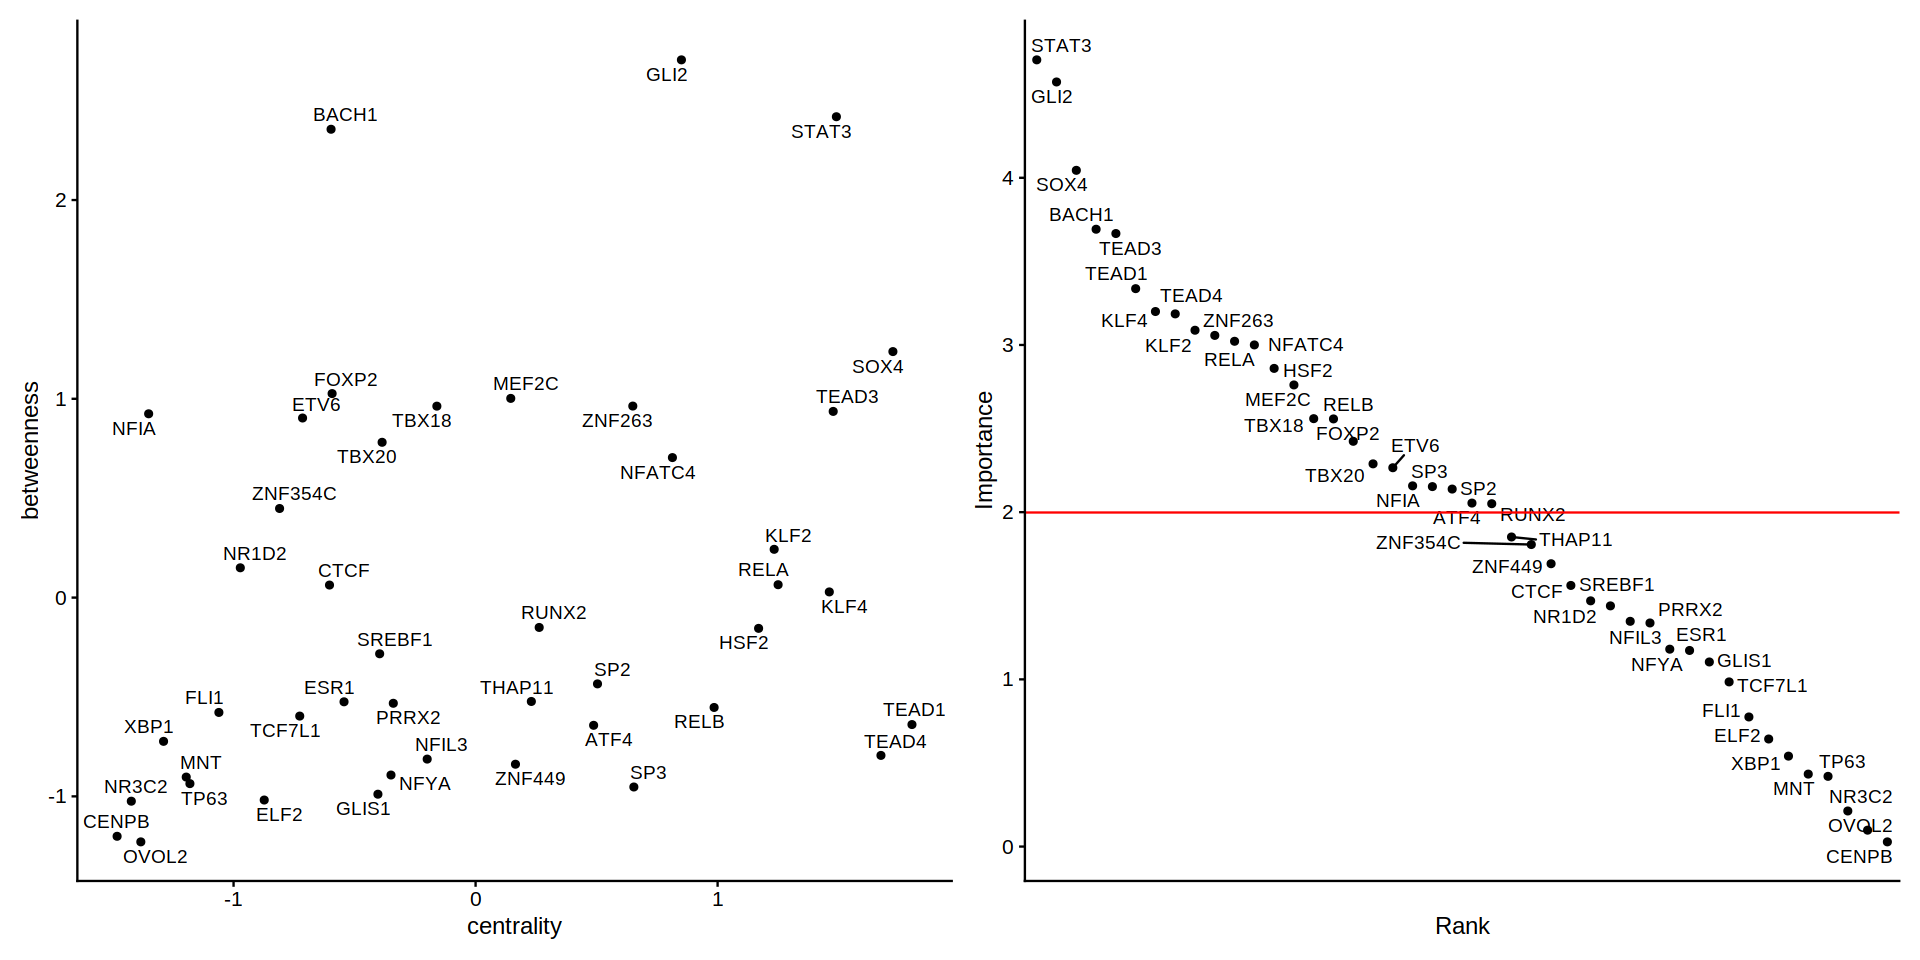

In [4]:
options(repr.plot.height = 8, repr.plot.width = 16)

p1 <- ggplot(data = df_measure, aes(x = page_scale, y = bet_scale)) +
    geom_point() +
    xlab("centrality") + ylab("betweenness") +
    geom_text_repel(aes(label = tf)) +
    theme_cowplot()

p2 <- ggplot(data = df_measure, aes(x = reorder(tf, -importance), y = importance)) +
    geom_point() +
    xlab("Rank") + ylab("Importance") +
    geom_text_repel(aes(label = tf)) +
    geom_hline(yintercept = 2, color = "red") +
    theme_cowplot() +
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank())
    
p1 + p2

In [5]:
## load clustering results for genes and pseudotime point for TFs
df_gene_clustering <- read.csv("../data/snATAC_SCARA5_Myofib/gene_cluster.csv",
                         row.names = 1) %>%
    mutate(gene = stringr::str_split_fixed(gene, ":", 2)[, 2]) %>%
    subset(gene %in% gene.list)

df_timepoint <- read.csv("../data/snATAC_SCARA5_Myofib/TF_time_point.csv",
                        row.names = 1) %>%
    select(matchname1, time_point) %>%
    rename(tf = matchname1) %>%
    subset(tf %in% tf.list)

head(df_gene_clustering)
head(df_timepoint)

,gene,cluster
,<chr>,<chr>
1,LTBP1,late_stage
3,BRD1,late_stage
11,RABGEF1,late_stage
12,ACTB,late_stage
13,GALNT1,late_stage
15,LGALS1,late_stage


,tf,time_point
,<chr>,<dbl>
78,KLF2,1.000000
121,KLF4,1.156646
106,SP3,2.723101
67,NFYA,4.289557
114,ATF4,5.386076
129,NFIL3,7.735759


In [6]:
# create graph from data frame
g <- graph_from_data_frame(df, directed=TRUE)

In [7]:
# assign size to each node
## for TFs, the size is proportional to the importance
tf_size <- df_measure$importance

## for genes, we use the minimum size of TFs
gene_size <- rep(min(df_measure$importance), length(gene.list))

names(tf_size) <- df_measure$tf
names(gene_size) <- gene.list

v_size <- c(tf_size, gene_size)

# add size
V(g)$size <- v_size[V(g)$name]

In [8]:
# assign color to each node
## TFs are colored by pseudotime point
df_timepoint <- df_timepoint[order(df_timepoint$time_point), ]

head(df_timepoint)

tf_color <- ArchR::paletteContinuous(set = "blueYellow", 
                                     n = nrow(df_timepoint))
names(tf_color) <- df_timepoint$tf

## genes are colored based on the clustering
gene_color <- stringr::str_replace_all(df_gene_clustering$cluster,
                                      c("early_stage" = "#208A42",
                                       "late_stage" = "#272E6A"))

names(gene_color) <- df_gene_clustering$gene

v_color <- c(tf_color, gene_color)

,tf,time_point
,<chr>,<dbl>
78,KLF2,1.000000
121,KLF4,1.156646
106,SP3,2.723101
67,NFYA,4.289557
114,ATF4,5.386076
129,NFIL3,7.735759


In [9]:
## assign alpha
tf_alpha <- rep(1, length(tf.list))
gene_alpha <- rep(0.5, length(gene.list))

names(tf_alpha) <- tf.list
names(gene_alpha) <- gene.list

v_alpha <- c(tf.list, gene.list)

V(g)$alpha <- v_alpha[V(g)$name]

In [19]:
# compute layout
set.seed(42)
layout <- layout_with_fr(g, weights = E(g)$correlation, dim = 2, niter = 1000)

Warning message:
“Using alpha for a discrete variable is not advised.”


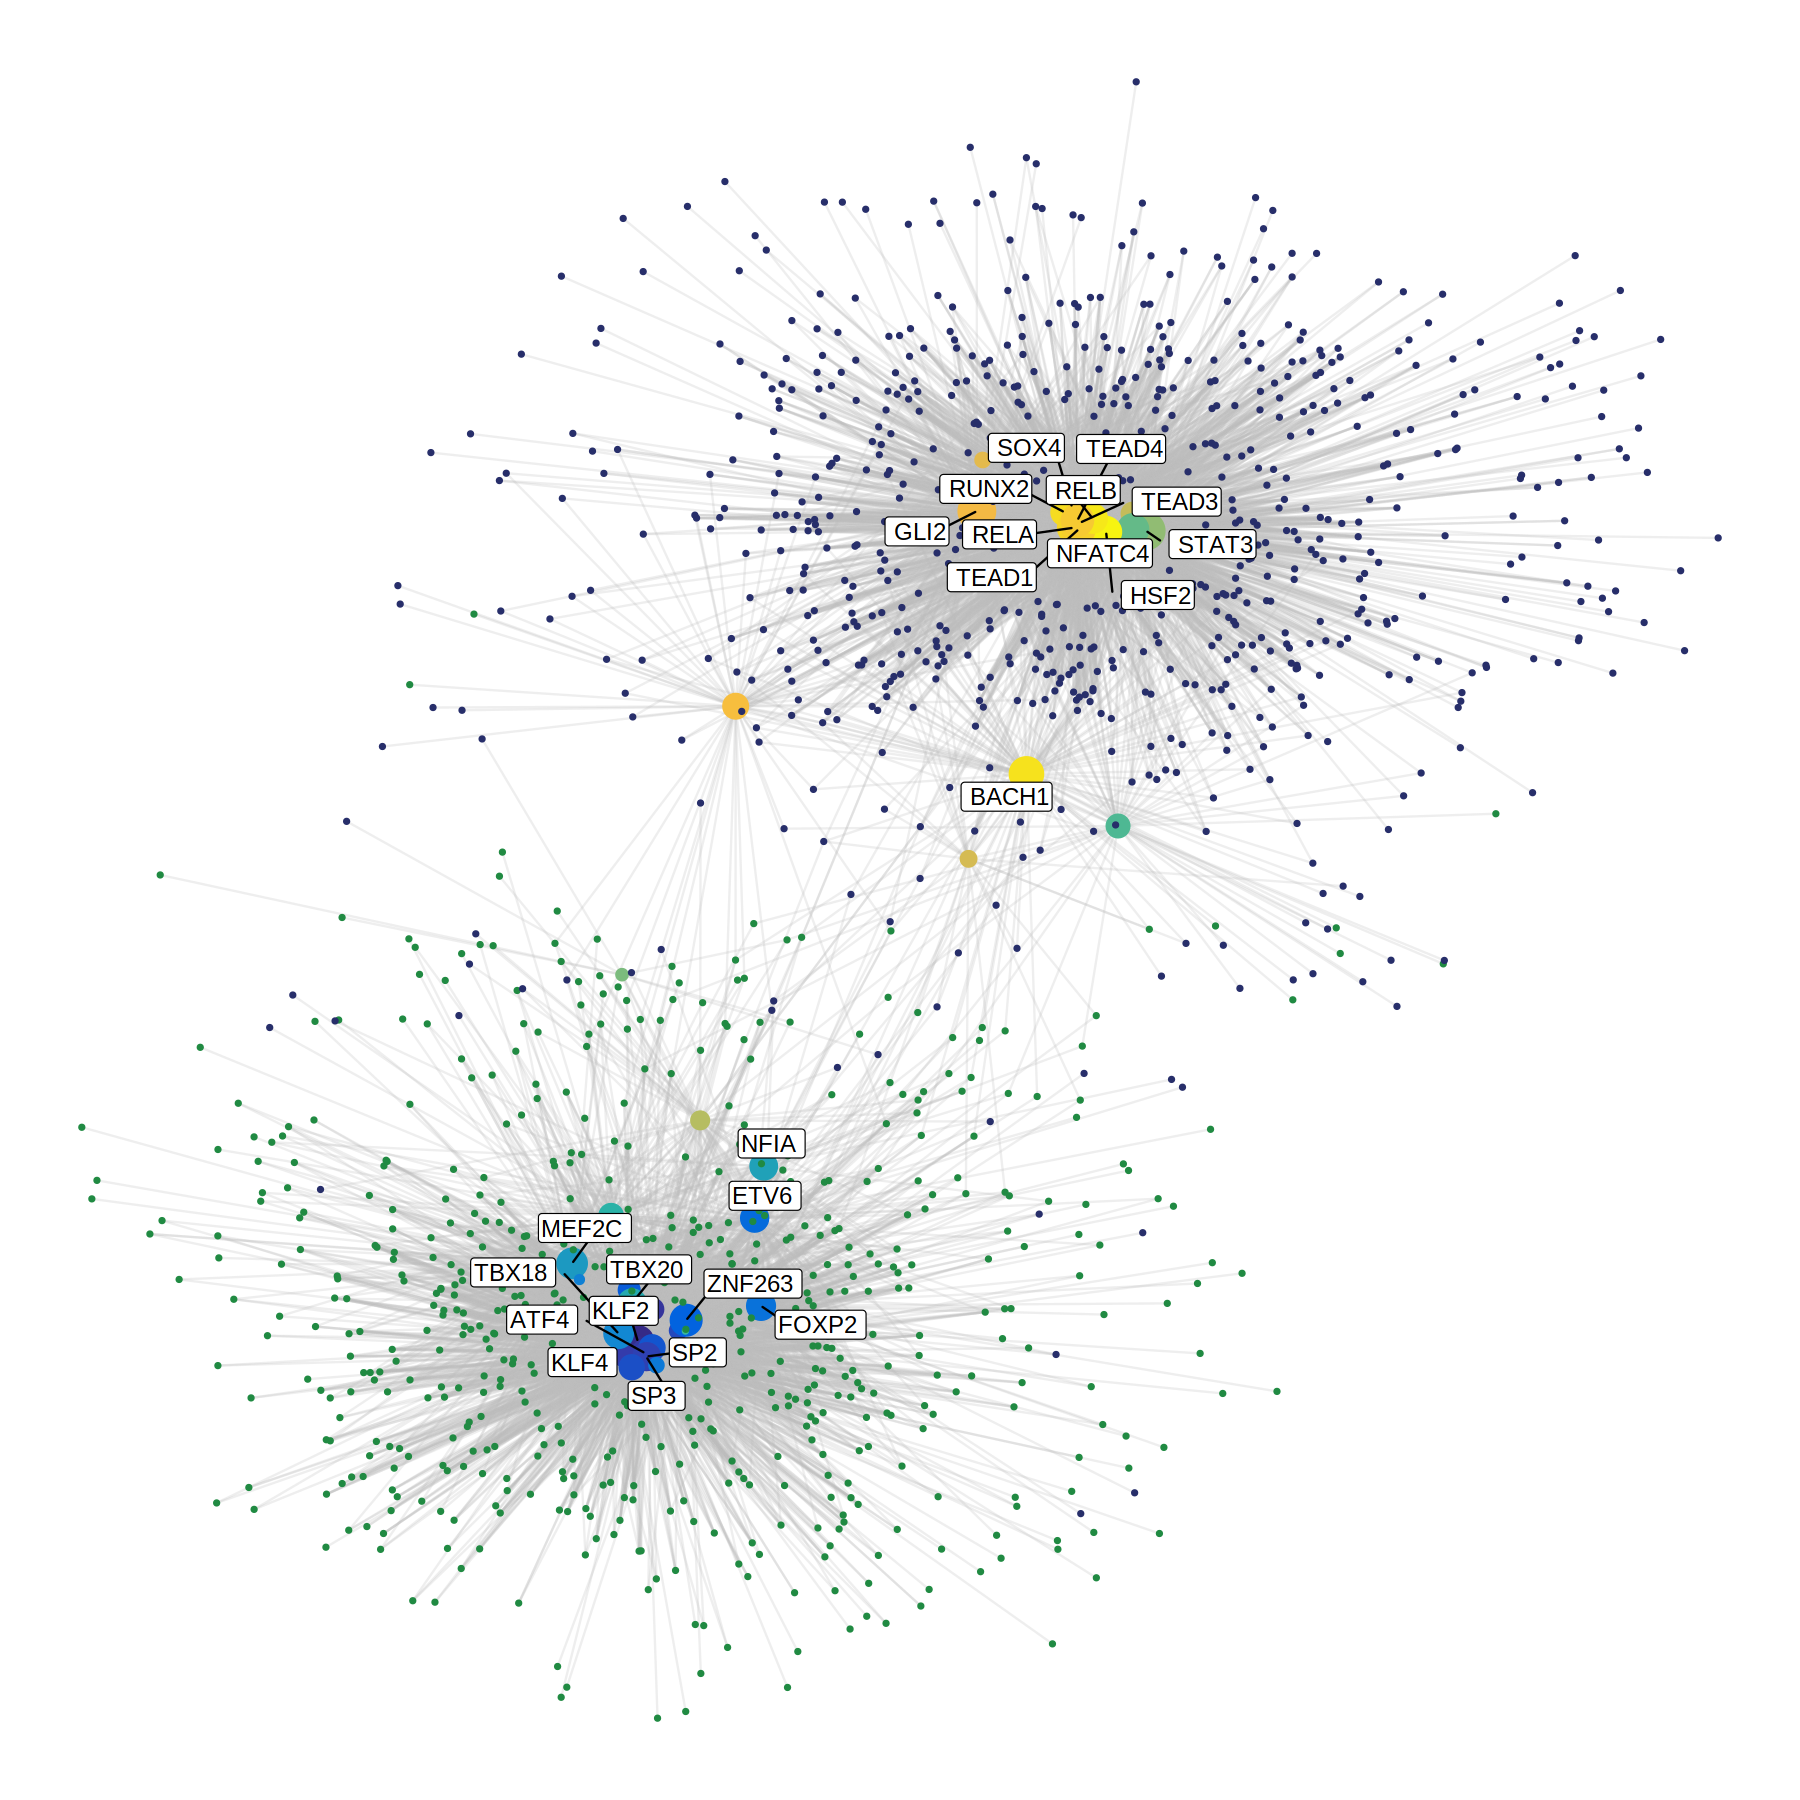

In [20]:
options(repr.plot.height = 15, repr.plot.width = 15)

df_measure_sub <- subset(df_measure, importance > 2)

ggraph(g, layout = layout) +
geom_edge_link(edge_colour = "gray", edge_alpha = 0.25) +
geom_node_point(aes(size = V(g)$size,
                   color = as.factor(name),
                   alpha = V(g)$alpha,
                   ),
                show.legend = FALSE) +
scale_size(range = c(1, 10)) +
scale_color_manual(values = v_color) +
geom_node_label(aes(filter = V(g)$name %in% df_measure_sub$tf,
                    label = V(g)$name),
                    repel = TRUE,
                    hjust = "inward",
                size = 5,
                max.overlaps = Inf,
                show.legend = FALSE) +
theme_void()

In [12]:
df <- subset(df, tf %in% df_measure_sub$tf)

In [13]:
unique(df$tf)

[1] "KLF2"   "KLF4"   "SP3"    "ATF4"   "ZNF263" "ETV6"   "FOXP2"  "MEF2C" 
 [9] "SP2"    "TBX18"  "TBX20"  "NFIA"   "BACH1"  "STAT3"  "SOX4"   "RUNX2" 
[17] "NFATC4" "RELA"   "GLI2"   "HSF2"   "TEAD3"  "TEAD1"  "RELB"   "TEAD4"

In [14]:
write.csv(df, "../data/snATAC_SCARA5_Myofib/gene_regulatory_network_filtered.csv")

In [21]:
df_go <- read.csv("../data/snATAC_SCARA5_Myofib/GO_analysis.csv",
                 row.names = 1) %>%
    mutate(p_value = -log10(p_value)) %>%
    subset(source == "GO:BP") %>%
    group_by(cluster) %>%
    slice_max(n = 10, order_by = p_value, with_ties = FALSE)

df_go

p_value,source,term_name,cluster
<dbl>,<chr>,<chr>,<chr>
10.032025,GO:BP,anatomical structure morphogenesis,early_stage
9.030357,GO:BP,cell adhesion,early_stage
9.030357,GO:BP,biological adhesion,early_stage
7.836682,GO:BP,anatomical structure development,early_stage
7.577127,GO:BP,developmental process,early_stage
7.089827,GO:BP,neuron development,early_stage
7.089827,GO:BP,extracellular matrix organization,early_stage
7.089827,GO:BP,extracellular structure organization,early_stage
7.089827,GO:BP,external encapsulating structure organization,early_stage


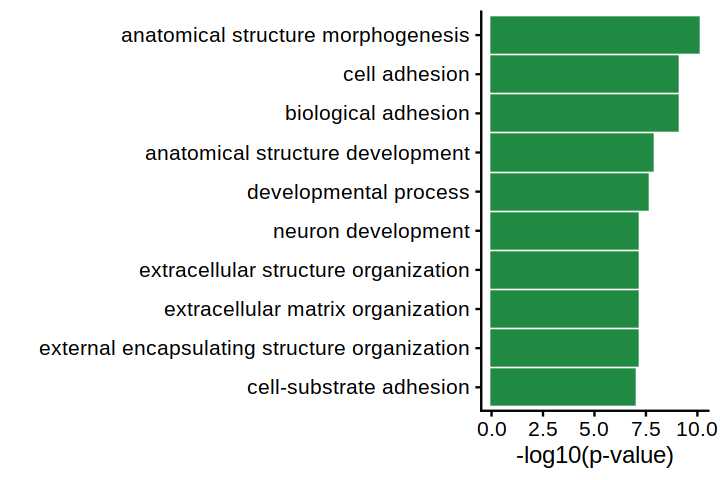

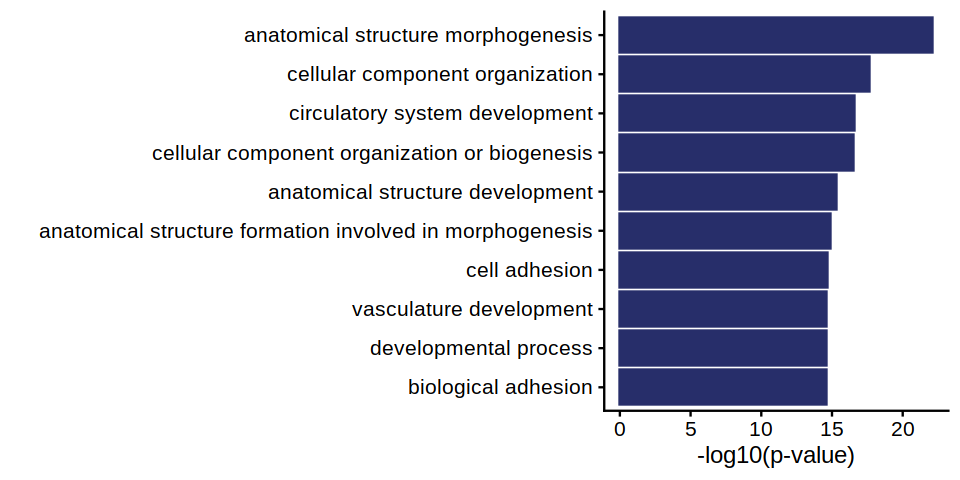

In [22]:
options(repr.plot.height = 4, repr.plot.width = 6)

p1 <- df_go %>%
    subset(cluster == "early_stage") %>%
    ggplot(aes(x = reorder(term_name, p_value), y = p_value)) +
    geom_bar(stat = "identity", color = "#208A42", fill = "#208A42") +
    xlab("") + ylab("-log10(p-value)") +
    theme_cowplot() +
    coord_flip()

p1

options(repr.plot.height = 4, repr.plot.width = 8)

p2 <- df_go %>%
    subset(cluster == "late_stage") %>%
    ggplot(aes(x = reorder(term_name, p_value), y = p_value)) +
    geom_bar(stat = "identity", color = "#272E6A", fill = "#272E6A") +
    xlab("") + ylab("-log10(p-value)") +
    theme_cowplot() +
    coord_flip()

p2